## IMPORTING LIBRARIES AND DATASET DOWNLOAD

In [6]:
# System Libraries
import os
from pathlib import Path
import tarfile
from IPython.display import Audio, clear_output

# Handling Data Libraries
import pandas as pd
import numpy as np

# Plot Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
'''
import librosa
import librosa.display
'''

# ML libraries
'''
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
'''

# DL libraries
'''
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
'''

# Handling warnings library
'''
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
''';

The dataset is distributed on this webpage https://sail.usc.edu/iemocap/ under request, after the request is accepted they provide you a download link that expire in 48 hours therefore we uploaded a lighter copy of it on kaggle as a private dataset (only the files we were interested in), therefore to run the following cell you just have to ask the access to Riccardo Paolini, we will provide you the access as soon as possible, then you have to download a ***kaggle.json*** file from kaggle to do that follow this steps:
- go to https://www.kaggle.com/
- sign up/in to your account on kaggle
- click on your propic in the top right corner
- click "Your Profile -> Account -> Create New API Token"

after this steps the download of your ***kaggle.json*** file should have started.
By running the following cell you are requested to upload the ***kaggle.json*** therefore the download of the private dataset should start.

## DATASET DESCRIPTION (Copy Paste of the README.txt file of the dataset)

Thank you for your interest in the USC_IEMOCAP database.  The USC_IEMOCAP database contains audio, transcriptions, video, and motion-capture(MoCap) recordings of dyadic mixed-gender pairs of actors.  There are five sessions in the database (ten actors total). For complete information about IEMOCAP please refer to:

Busso, Carlos et al.  "IEMOCAP: Interactive emotional dyadic motion capture database."  Journal of Language Resources and Evaluation.  Volume 42, Number 4.  pp. 335-359.  2008

as well as our website: http://sail.usc.edu/iemocap/

The recorded dialogs are either improvisations of affective scenarios, or performances of theatrical scripts. They have been manually segmented into utterances. Each utterance from either of the actors in the interaction has been evaluated categorically over the set of: {angry, happy, sad, neutral, frustrated, excited, fearful, surprised, disgusted, other} by at least three different annotators, and dimensionally over the axes of: valence (positive vs. negative); activation (calm vs. excited); and dominance (passive vs. aggressive) by at least two different annotators. 

In each recording of a session only one actor wears MoCap markers while both are being recorded by microphones and cameras. Thus there are available MoCap data (facial expression, head and hand movement) for one actor per recording, while there are wavefile and videos for both actors. The naming convention regarding the data is e.g., Ses01F_impro01 while indicates Session1, where the Female actor is wearing the markers and actors are performing improvisation 1. The release contains two formats: dialog format which contains data from the entire dyadic interaction and the sentence format where the data per dialog (recording) have been further segmented into utterances (see folders SessionX/dialog and SessionX/sentences respectively). For the utterance format the naming is as follows: Ses01F_impro01_M000 indicates first session, Female actor is wearing markers, actors are performing improvisation 1 and this is the first utterance of the Male actor. The timing of the sentences in each dialog can be found in the lab files in SessionX/dialog/lab

The MoCap data can be found in either dialog format or sentece format in the corresposding folders. The MOCAP_rotated folder contains motion-capture data rotated and translated such that the central nose marker always represents the (0,0,0) xyz-tuple. The MoCap data are in .txt files where each line is a frame number and each column is a marker coordinate. Please consult the headers of the MoCap files and the diagram of the facial markers (Documentation/FIVE_face_markers2.png) to see the correspondence between marker positions and marker names. The hand mocap data is in MOCAP_hand folder, while the information of head translation (x,y,z) and head rotation (yaw, pitch, roll) is in MOCAP_head folder. 

We are also distributing wavefiles (sentence and dialog format), the videos of the recordings (SessionX/dialog/avi/), and transcriptions of the dialogs (SessionX/dialog/transcriptions/). For the segmented utterances we are also providing the results of forced alignment which contain detail phoneme, syllable and word level timing information (SessionX/sentences/ForcedAlignment/).

The evaluations (emotional annotations) for each recording and each uterance are contained in folder SessionX/dialog/Evaluation/. Each file provides the detailed evaluation reports for the categorical evaluators (e.g., C-E1), the dimensional evaluators (e.g., A-E1), and the self-evaluatiors (e.g., C-F1 or C-M1, A-F1 or A-M1). The utterance-level information can be found in the first line of an utterance summary.  The first entry represents the start and end times for the utterance.  The second entry is the utterance name (e.g., Ses01_impro01_F003).  The third entry is the ground truth (if no majority ground truth could be assigned, the ground truth is labeled xxx).  The final engry is the average dimensional evaluation (over the evaluators, except the self-evaluators).

We are providing  a full release of this data in the hopes that it will provide a valuable resource to the emotion recognition community. We request that any published work using IEMOCAP should cite the paper entitled: "IEMOCAP: Interactive emotional dyadic motion capture database" (JLRE, 2008). If you do any further evaluation of the data, we request that you send us the detailed results so that we may provide a more detailed resource to the community. Also, please feel free to send us feedback regarding the database: how it is being used, if the information provided is sufficient, and how you have decided to utilize the evaluation information. Thanks again.


## BUILDING OF A DATAFRAME

In [7]:
#folder = os.path.join(os.getcwd(), 'IEMOCAP')
folder = '../input/iemocap'

conv_id = 0

df = []
for session in os.listdir(folder):
    session_path = os.path.join(folder, session)
    # 'dialogue' folder contains Emotions and Transcripts
    # 'sentences' folder contains Audios

    trans_folder = os.path.join(session_path, 'dialog', 'transcriptions')

    for trans_name in os.listdir(trans_folder):
        if trans_name[:2] != '._':
            emo_path = os.path.join(session_path, 'dialog', 'EmoEvaluation', trans_name)
            with open(os.path.join(trans_folder, trans_name), encoding='utf8') as trans_file, open(emo_path, encoding='utf8') as emo_file:
                conv_id += 1
                turn_id = 0
                for line in trans_file:
                    audio_name, text = line.split(':')
                    if trans_name.split('.')[0] in audio_name:
                        turn_id += 1

                        wav_path = os.path.join(session_path, 'sentences', 'wav', trans_name.split('.')[0], audio_name.split(' ')[0] + '.wav')

                        reached = False
                        count_em = {'Anger': 0, 'Happiness': 0, 'Sadness': 0, 'Neutral': 0, 'Frustration': 0, 'Excited': 0, 'Fear': 0, 'Surprise': 0, 'Disgust': 0, 'Other': 0}
                        for emo_line in emo_file:
                            if audio_name.split(' ')[0] in emo_line:
                                emotion, vad = emo_line.split('\t')[-2:]
                                vad = vad[1:-2].split(',')
                                reached = True
                            elif emo_line[0] == 'C' and reached:
                                evaluator = emo_line.split(':')[0]
                                emotions = emo_line.split(':')[1].split('(')[0].split(';')
                                emotions = [em.strip() for em in emotions]
                                for em in emotions:
                                    if em != '':
                                        count_em[em] += 1
                            elif reached:
                                emo_file.seek(0)
                                break
                                    

                        row = {'conv_id': conv_id, 
                                'turn_id': turn_id, 
                                'sentence': text.strip(),
                                'path': wav_path,
                                'emotion': emotion,
                                'valence': float(vad[0]),
                                'activation': float(vad[1]),
                                'dominance': float(vad[2])
                                }
                        
                        df.append(dict(**row, **count_em))

df = pd.DataFrame(df)


### DATAFRAME INSPECTION

In [11]:
df.sample(50)

,conv_id,turn_id,sentence,path,emotion,valence,activation,dominance,Anger,Happiness,Sadness,Neutral,Frustration,Excited,Fear,Surprise,Disgust,Other
551,9,20,"Yeah, I would love to. Thanks. [LAUGHTER]",../input/iemocap/Session4/sentences/wav/Ses04M...,exc,4.5,3.5000,3.5000,0,0,0,0,0,3,0,0,0,0
1019,15,49,"Thank you, dear. The same applies to you exce...",../input/iemocap/Session4/sentences/wav/Ses04F...,exc,4.0,3.5000,4.5000,0,1,0,0,0,2,0,0,0,0
1675,26,33,Pass up what? These little fish swim onto the...,../input/iemocap/Session4/sentences/wav/Ses04M...,ang,2.0,4.0000,3.0000,3,0,0,0,0,0,0,0,0,0
4777,68,37,She used to have these poetry parties on Memor...,../input/iemocap/Session1/sentences/wav/Ses01F...,sad,4.0,3.0000,3.5000,0,1,4,0,0,1,0,0,0,0
7078,105,24,"Uh-huh, uh-huh.",../input/iemocap/Session3/sentences/wav/Ses03F...,xxx,3.5,3.5000,2.5000,0,0,0,0,0,0,0,0,0,0
3511,49,75,Turn it off!,../input/iemocap/Session5/sentences/wav/Ses05M...,ang,1.5,4.0000,4.5000,3,0,0,0,0,0,0,0,0,0
9545,142,16,"I didn't have like one of those starts, you kn...",../input/iemocap/Session2/sentences/wav/Ses02F...,fru,2.0,3.5000,4.0000,0,0,1,0,3,0,0,0,0,0
3178,46,3,I got it. I got accepted to U.S.C..,../input/iemocap/Session5/sentences/wav/Ses05M...,exc,5.0,3.0000,2.5000,0,1,0,0,0,3,0,0,0,0
9957,149,37,What?,../input/iemocap/Session2/sentences/wav/Ses02M...,exc,3.5,3.0000,3.0000,0,1,0,0,0,2,0,0,0,0
2965,43,14,I just - We just have different ideas of what ...,../input/iemocap/Session5/sentences/wav/Ses05M...,fru,2.0,3.6667,2.6667,1,0,0,0,2,0,0,0,0,0


### AUDIO INSPECTION

In [4]:
Audio(df.iloc[0, 3]) # ispection of the first audio (to change audio just change the first index)

### GOLDEN LABELS INSPECTION

In [6]:
for em in np.unique(df.emotion):    
    print(f"emotion {em}: {np.sum(df.emotion == em)}")

emotion ang: 1111

emotion dis: 1

emotion exc: 1108

emotion fea: 35

emotion fru: 2053

emotion hap: 541

emotion neu: 1634

emotion oth: 3

emotion sad: 1089

emotion sur: 99

emotion xxx: 2413


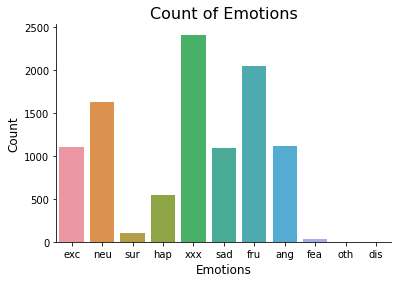

In [8]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=df.emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Let's do some consideration of the above plotted distribution of this golden labels:

- We can see how the emotion "xxx" is very common emotion (almost 2500 occurrences) but not very meaningful, our explanation behind the behavior of this golden label is that there isn't a predominant emotion in the classifications of the evaluators (excluding the self-evaluator) therefore an "xxx" gold label shows up.

- We can see that a lot of our labels are undersampled in comparison to the other labels, data augmentation could help in this cases

The strategies that we thinked of for handling the "xxx" labels are by considering them as missing values and trying to fill them by reconstruct a predominant emotion also considering the self-evaluators with more weights with respect to the other evaluators, but that would by definition modify the golden label we are provided with.

## VAD Inspection (Valence, Activation, Dominance)

In [9]:
interactive = True # CHANGE THIS TO False IN ORDER TO SEE AN INTERACTIVE PLOT
title = "VAD Inspection with reference to golden labels"

if interactive:
    fig = px.scatter_3d(df, x='valence', y='activation', z='dominance',
                        color='emotion',
                        title=title)
    fig.show()
else:
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(15,10), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111, projection = '3d')

    for e in df.emotion.unique():
        ax.scatter(df.valence[df.emotion == e], df.activation[df.emotion == e], df.dominance[df.emotion == e], label = e)

    ax.set_xlabel("valence")
    ax.set_ylabel("activation")
    ax.set_zlabel("dominance")

    ax.legend()

    plt.title(title)
    plt.show()

The only inspection for the VAD values that came in our mind is a visual inspection with reference to the golden labels and it seems that the golden labels are reflected in the VAD space with some clusters, that doesn't seem to be the case for the 'xxx' label that seems to be distributed quite randomly in this space.

# Text Classification



In [20]:
# Examples of texts.

for i in range(10):
    print(i, df.sentence.values[i])

0 Hey, how you doing?
1 I'm sorry.
2 Thanks.
3 I know- I know there's nothing I can say that will really help, but--
4 I know.  I just -- I don't know.  It's just weird because you have somebody who's, you know,
5 a major part of your life and then they're gone.  And I don't know.  That's not really -- it's never really happened to me before.
6 I'm sorry.  It's never easy.
7 Yeah.
8 But, I'm here if there's anything you need.  I mean, you just have to ask.  I know --
9 Thanks.


In [41]:
# Split the data in to train and test

from sklearn.model_selection import train_test_split, StratifiedKFold

X_train, X_test, y_train, y_text = train_test_split(df.sentence.values, df.emotion.values, test_size=0.2, shuffle=True, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(X_train[0])

(8069,)
(2018,)
You can't--  This is not the line for Z.X.four.  If you're going to fill out the Z.X.four, you need to have a different form of ID.


# Create  Vocabulary - INCOMPLETE!

In [72]:
text = X_train[0]
print(text)

l = text.lower().split('.')
text = ''.join(l)
set(text.split())

You can't--  This is not the line for Z.X.four.  If you're going to fill out the Z.X.four, you need to have a different form of ID.


{'a',
 "can't--",
 'different',
 'fill',
 'for',
 'form',
 'going',
 'have',
 'id',
 'if',
 'is',
 'line',
 'need',
 'not',
 'of',
 'out',
 'the',
 'this',
 'to',
 'you',
 "you're",
 'zxfour',
 'zxfour,'}

# Tokenize the text with `tf.keras.layers.TextVectorization()` 

In [76]:
import tensorflow as tf

'''
TextVectorization = tf.keras.layers.TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8' #,**kwargs
)
'''

# Create the layer.  

max_features = 5000  # Maximum vocab size.
max_len = 5  # Sequence length to pad the outputs to.
embedding_dim = 4

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    pad_to_max_tokens=False,
    max_tokens=max_features, # Maximum vocab size.
    output_mode='int',
    output_sequence_length=max_len
)

# Add vocabulary file
vocabulary = ["foo", "bar", "baz"]
text_dataset = tf.data.Dataset.from_tensor_slices(vocabulary)
vectorize_layer.adapt(text_dataset.batch(64))

# Example illustration ...

In [85]:
# Model
model = tf.keras.models.Sequential()

# Input layer 
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# Vectorize the text
model.add(vectorize_layer)

# Embedding layer of dimension embedding_dim
model.add(tf.keras.layers.Embedding(max_features, embedding_dim))

# Make prediction ...
input_data = [["foo qux bar"], ["qux baz"]]
print('Shape = ', model.predict(input_data)[0].shape)
print()
print(
model.predict(input_data)
)

1/1 [==============================] - 0s 118ms/step
Shape =  (5, 4)

1/1 [==============================] - 0s 41ms/step
[[[ 0.02965153 -0.01270616  0.01000942  0.04184132]
  [-0.00083565 -0.02430554  0.00088608 -0.01107854]
  [ 0.01151901  0.00789969  0.00917407 -0.01985723]
  [ 0.02985016 -0.0252611  -0.02239863  0.01038221]
  [ 0.02985016 -0.0252611  -0.02239863  0.01038221]]

 [[-0.00083565 -0.02430554  0.00088608 -0.01107854]
  [ 0.03459436  0.01056012  0.02850013  0.04290077]
  [ 0.02985016 -0.0252611  -0.02239863  0.01038221]
  [ 0.02985016 -0.0252611  -0.02239863  0.01038221]
  [ 0.02985016 -0.0252611  -0.02239863  0.01038221]]]


# Model

In [ ]:
def model(max_features, embedding_dim, n_class_labels = 1):
    
    from tf.keras import layers

    # A integer input for vocab indices.
    inputs = tf.keras.Input(shape=(None,), dtype="int64")

    # Next, we add a layer to map those vocab indices into a space of dimensionality
    # 'embedding_dim'.
    x = layers.Embedding(max_features, embedding_dim)(inputs)
    x = layers.Dropout(0.5)(x)

    # Conv1D + global max pooling
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.GlobalMaxPooling1D()(x)

    # We add a vanilla hidden layer:
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    # We project onto a single unit output layer, and squash it with a sigmoid:
    predictions = layers.Dense(n_class_labels, activation="sigmoid", name="predictions")(x)

    model = tf.keras.Model(inputs, predictions)

    # Compile the model with binary crossentropy loss and an adam optimizer.
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model
